# **Laboratorium - Wykorzystanie przetrenowanych sieci neuronowych do ekstrakcji cech i transfer learning**

Sklad sekcji:

Dolaczenie modulow wykorzystywanych na potrzeby laboratorium:

In [20]:
from tensorflow.keras.applications import Xception, InceptionV3
# nalezy wykorzystac odpowiednia funkcje do preprocessingu - nalezy ja znalezc za 
# posrednictem keras applications i strony dla odpowiedniego modelu
from tensorflow.keras.applications.inception_v3 import preprocess_input 
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import glob, os

Ponizej zawarto definicje funkcji, ktore mozna wykorzystac do realizacji zadan laboratoryjnych oraz ich przyklady wywolania:

In [21]:
def read_img(filename, size):
    img = load_img(filename, target_size=size)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

# Example: img = read_img("img.jpg", (299, 299)) - wczytanie pliku img.jpg znajdujacego sie w tym samym folderze co notebook, 
# wynikowy rozmiar obrazu to 299x299 (i trzy kanaly - kodowanie rgb)

def create_dataset(main_folder_path, size):
    X = []
    y = []

    os.chdir(".")
    for file in glob.glob(main_folder_path + "/*/*.jp*"):
        X.append(read_img(file, size))
        y.append(file.split('\\')[1])
    X = np.asarray(X)
    y = np.asarray(y).astype('float32')
    return X, y

# Example: X, y = create_dataset("faces", (299, 299)) - wczytanie zbioru z folderu faces, w folderze znajduja sie dwa pofoldery - o nazwach 0 i 1, 
# a w nich zdjecia w formacie jpeg lub jpg, wynikowy rozmiar obrazów to 299x299 (i trzy kanaly - kodowanie rgb)

def plot_images(X, y, rows=2, cols=5, clustering=False, nntesting=False, y_pred=None):
    # rows - number of classes - 2
    # cols - number of instances in one class - 5 images per class
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 7))
    counter = 0
    for row in range(rows):
        for col in range(cols):
            ax[row][col].imshow(X[counter] * 0.5 + 0.5)
            if not clustering and not nntesting:
                ax[row][col].set_title(f"label:{y[counter]}")
            else:
                if clustering:
                    ax[row][col].set_title(f"cluster number:{y[counter]}")
                else:
                    ax[row][col].set_title(f"true:{y[counter]} predicted:{y_pred[counter]}")
            counter += 1
    plt.show()

# Example: 
# plot_images(X, y) - wyswietlenie zbioru treningowego/do grupowania z 10 elementami (5 na klase)
# plot_images(X_test, y_test, rows=2, cols=2) - wyswietlenie zbioru testowego z 4 elementami (2 na klase)
# plot_images(X, kmeans_prediction, clustering=True) - wywolanie do wyswietlenia wynikow grupowania
# plot_images(X_test, y_test, rows=2, cols=2, clustering=False, nntesting=True, y_pred=nn_pred.reshape(nn_pred.shape[0])) - wyswietlenie wynikow klasyfikacji dla zbioru testowego
# plot_images(X, y, clustering=False, nntesting=True, y_pred=nn_pred.reshape(nn_pred.shape[0])) - wyswietlenie wynikow klasyfikacji dla zbioru treningowego

Do zmiennych X, y oraz X_test, y_test nalezy wczytac obrazy ze stworzonych folderow. W X i X_test przechowywane są tabele reprezentujace obrazy, a w y i y_test - labele.

In [22]:
X, y = create_dataset("treningowy", (299, 299))
X_test, y_test = create_dataset("testowy", (299, 299))

Po wczytaniu tablice powinny miec nastepujace wymiary:

In [23]:
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X shape: (10, 299, 299, 3), y shape: (10,)
X_test shape: (4, 299, 299, 3), y_test shape: (4,)


Nastepnie nalezy wyswietlic obrazy w zbiorach:

Train:


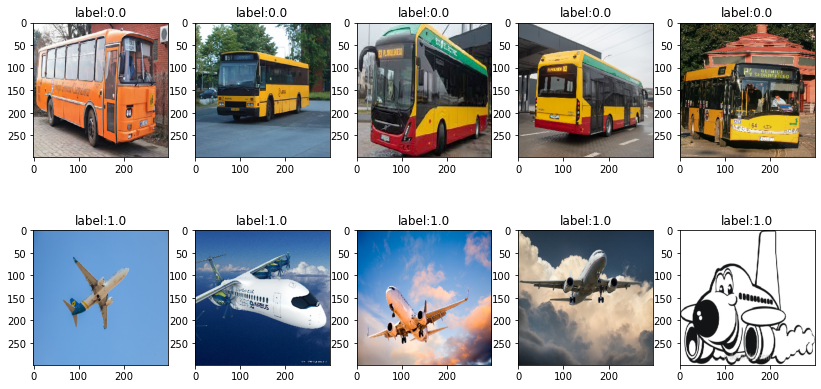

Test:


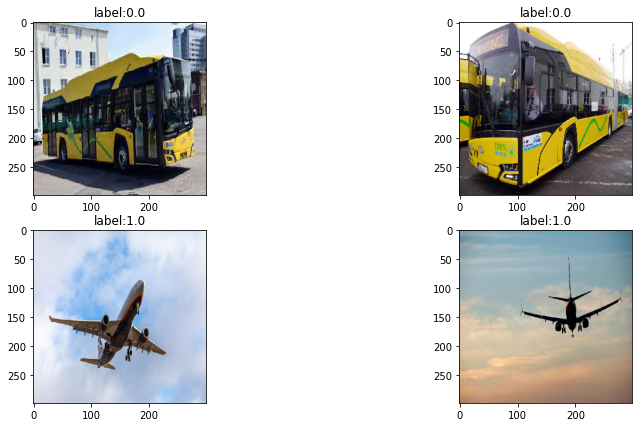

In [24]:
print("Train:")
plot_images(X, y)
print("Test:")
plot_images(X_test, y_test, rows=2, cols=2)

## **Grupowanie**

Wczytanie modelu (bedzie traktowany dalej jako model bazowy) i wyswietlenie jego podsumowania. Prosze skorzystac z modeli Xception lub InceptionV3.

In [92]:
from keras import Model
# Wczytanie wybranego modelu - przyklad - model Xception
model = Xception()

model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_115 (Add)                  (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_114[0][0]']                
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_115[0][0]']                
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_118 (

Funkcja summary nie wyswietla jednak nazw warstw, a jedynie typy. W celu wyswietlenia nazw, za pomoca ktorych mozna dostac sie do konkretnych warstw nalezy zapisac je do listy i wyswietlic:

In [93]:
# zapisanie do listy nazw warstw
model_layers = [layer.name for layer in model.layers]
print(model_layers)

['input_10', 'block1_conv1', 'block1_conv1_bn', 'block1_conv1_act', 'block1_conv2', 'block1_conv2_bn', 'block1_conv2_act', 'block2_sepconv1', 'block2_sepconv1_bn', 'block2_sepconv2_act', 'block2_sepconv2', 'block2_sepconv2_bn', 'conv2d_40', 'block2_pool', 'batch_normalization_36', 'add_108', 'block3_sepconv1_act', 'block3_sepconv1', 'block3_sepconv1_bn', 'block3_sepconv2_act', 'block3_sepconv2', 'block3_sepconv2_bn', 'conv2d_41', 'block3_pool', 'batch_normalization_37', 'add_109', 'block4_sepconv1_act', 'block4_sepconv1', 'block4_sepconv1_bn', 'block4_sepconv2_act', 'block4_sepconv2', 'block4_sepconv2_bn', 'conv2d_42', 'block4_pool', 'batch_normalization_38', 'add_110', 'block5_sepconv1_act', 'block5_sepconv1', 'block5_sepconv1_bn', 'block5_sepconv2_act', 'block5_sepconv2', 'block5_sepconv2_bn', 'block5_sepconv3_act', 'block5_sepconv3', 'block5_sepconv3_bn', 'add_111', 'block6_sepconv1_act', 'block6_sepconv1', 'block6_sepconv1_bn', 'block6_sepconv2_act', 'block6_sepconv2', 'block6_sepc

Wykorzystaj wyzej wczytany model podstawowy (np. Xception) i zbuduj model do ekstrakcji cech. Wykorzystaj parametr modelu input oraz funkcje get_layer (nazwe warstwy wybierz z listy warstw powyzej - ma to byc warstwa przed klasyfikatorem - splaszczajaca dane, np. average pooling) wraz z parametrem output. Wykorzystaj te dwie czesci i zbuduj model z pomoca funkcji Model. Model nazwac model_embeddings.

Hint:

https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction

In [99]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

layer_name = 'avg_pool'
model_embeddings = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
intermediate_output = model_embeddings(X)

In [100]:
intermediate_output.shape

TensorShape([10, 2048])

Wygenerowanie cech (ekstrakcja cech) za pomoca stworzonego modelu:

In [101]:
pred_intermediate = model_embeddings.predict(X)

In [106]:
preds = model.predict(X)

Dokonaj predykcji (funkcja predict modelu) i wykorzystaj funkcje decode_predictions z keras.applications.imagenet_utils do zdekodowania 5 najbardziej prawdobodobych predykcji zwroconych przez model i wypisz je (dla wszystkich obrazkow w zbiorze).

In [107]:
tf.keras.applications.imagenet_utils.decode_predictions(preds, top=5)

49152/35363 [=========================================] - 0s 0us/step


[[('n04146614', 'school_bus', 0.8343739),
  ('n04487081', 'trolleybus', 0.049158648),
  ('n03769881', 'minibus', 0.013358986),
  ('n03895866', 'passenger_car', 0.0057711066),
  ('n03345487', 'fire_engine', 0.0016496632)],
 [('n04146614', 'school_bus', 0.53532875),
  ('n04487081', 'trolleybus', 0.21029864),
  ('n03895866', 'passenger_car', 0.15439472),
  ('n03769881', 'minibus', 0.0013020639),
  ('n04041544', 'radio', 0.0011693774)],
 [('n04487081', 'trolleybus', 0.761571),
  ('n03895866', 'passenger_car', 0.15234849),
  ('n03769881', 'minibus', 0.01479075),
  ('n04146614', 'school_bus', 0.0087646665),
  ('n04065272', 'recreational_vehicle', 0.0014561933)],
 [('n04146614', 'school_bus', 0.39574012),
  ('n04487081', 'trolleybus', 0.38340047),
  ('n03895866', 'passenger_car', 0.058231305),
  ('n03769881', 'minibus', 0.0049393647),
  ('n04065272', 'recreational_vehicle', 0.001937243)],
 [('n04487081', 'trolleybus', 0.8680926),
  ('n04335435', 'streetcar', 0.0050458936),
  ('n04146614', 'sc

Zmiana ksztaltu tablicy z labelami (aby mozliwy byl zapis do DataFrame):

In [108]:
y_reshaped = y.reshape(y.shape[0], 1)
print(f"Shape of y_reshaped: {y_reshaped.shape}")

Shape of y_reshaped: (10, 1)


Z wykorzystaniem struktury DataFrame z bibioteki pandas cechy z sieci konwolucyjnej (embeddings/bottlneck features) sa zapisywane wraz z labelem do tablicy - df:

In [109]:
import pandas as pd
features = [f"feature_{i}" for i in range(0, pred_intermediate.shape[-1])]
features.append("label")
df_values = np.concatenate((pred_intermediate, y_reshaped), axis=-1)
df = pd.DataFrame(df_values, columns=features)

Wyswietlenie zawartosci df:

In [110]:
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_2039,feature_2040,feature_2041,feature_2042,feature_2043,feature_2044,feature_2045,feature_2046,feature_2047,label
0,0.017354,0.006684,0.099545,0.366063,0.005532,0.067529,0.216320,0.070392,0.011195,0.330159,...,0.000230,0.667945,0.000000,0.133838,0.129766,0.471396,0.216472,0.037535,0.368335,0.0
1,0.000000,0.000000,0.000000,0.125888,0.000000,0.003828,0.410590,0.000000,0.000000,0.572722,...,0.000000,0.424658,0.000000,0.003922,0.000000,0.389322,0.013711,0.000000,0.595387,0.0
2,0.001339,0.093283,0.032859,0.013579,0.010171,0.044307,0.162504,0.000812,0.000000,0.522446,...,0.000000,0.247199,0.000000,0.027278,0.106307,0.388794,0.282798,0.203507,0.456865,0.0
3,0.013757,0.253263,0.056511,0.353930,0.000000,0.000848,0.046926,0.053485,0.000000,0.421387,...,0.000000,0.458173,0.001247,0.028715,0.005674,0.077220,0.121259,0.002127,0.444566,0.0
4,0.002632,0.101920,0.047434,0.017147,0.009830,0.046635,0.039966,0.000267,0.000000,0.640754,...,0.000000,0.141959,0.000000,0.000000,0.205917,0.016653,0.157055,0.139845,0.371928,0.0
5,0.409978,0.128633,0.000000,0.000420,0.035769,0.000202,0.164358,0.286689,0.299549,0.169255,...,0.385963,0.440044,0.017750,0.176899,0.110720,0.160433,0.167110,0.228779,0.204117,1.0
6,0.128744,0.000000,0.001781,0.000000,0.011888,0.034144,0.041641,0.466357,0.353925,0.092721,...,0.388085,0.483017,0.235828,0.219098,0.033803,0.227009,0.000000,0.150881,0.304611,1.0
7,0.203130,0.012427,0.130559,0.003884,0.031205,0.000000,0.036508,0.519254,0.418116,0.017834,...,0.570796,0.338385,0.096159,0.133984,0.103139,0.197561,0.008872,0.065808,0.182017,1.0
8,0.418225,0.013108,0.049812,0.000000,0.007155,0.000000,0.012744,0.703689,0.441950,0.001375,...,0.481932,0.404600,0.052593,0.054937,0.003482,0.002497,0.074532,0.131679,0.175558,1.0
9,0.347501,0.031366,0.000000,0.345593,0.006194,0.030400,0.058869,0.229908,0.070661,0.281776,...,0.005352,0.000000,0.024277,0.043635,0.038918,0.000000,0.000000,0.677599,0.045703,1.0


Zapis do pliku csv:

In [112]:
df.to_csv("dataset_treningowe.csv", index=False)

Wykorzystac algorytm kmeans (KMeans z modulu cluster biblioteki sklearn), dopasowac go do danych przechowywanych w pred_intermediate, dokonac predykcji i jej wyniki zapisac do zmiennej kmeans_prediction. 

Hint:

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [120]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(df.iloc[:,:2048], df.iloc[:,-1])
kmeans_prediction = kmeans.predict(df.iloc[:,:2048])

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Wyswietlic wyniki grupowania wraz z obrazami:

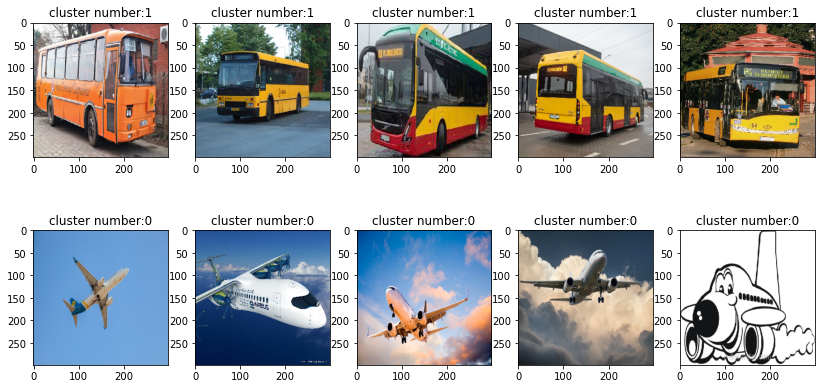

In [121]:
plot_images(X, kmeans_prediction, clustering=True)

Wyswietl workflow i rezultaty uzyskane w programie Orange:

Orange workflow


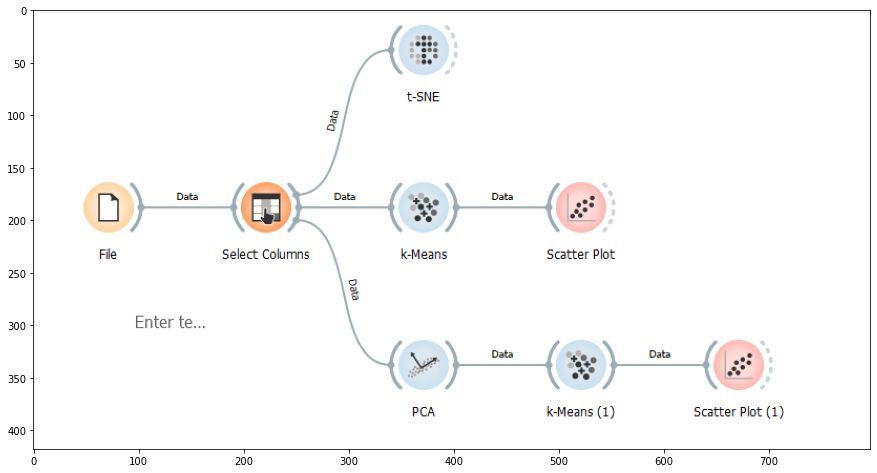

t-SNE results:


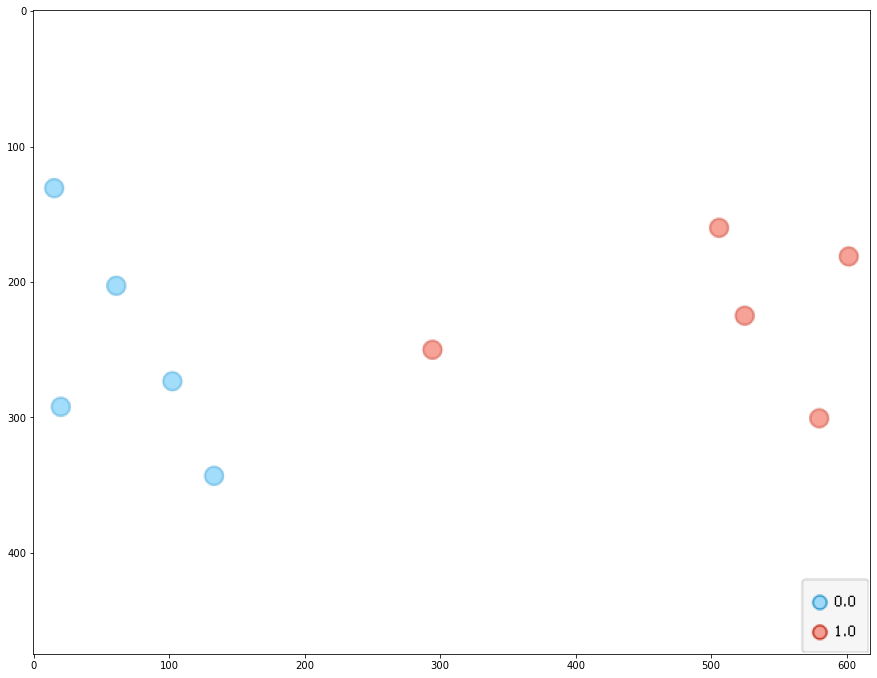

Raw kmenas results:


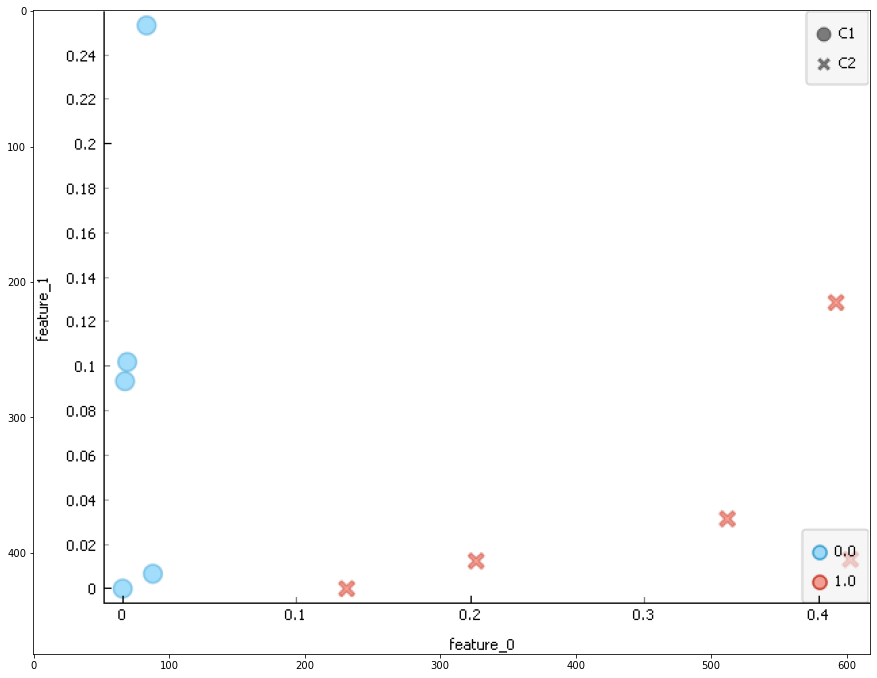

PCA + kmeans results:


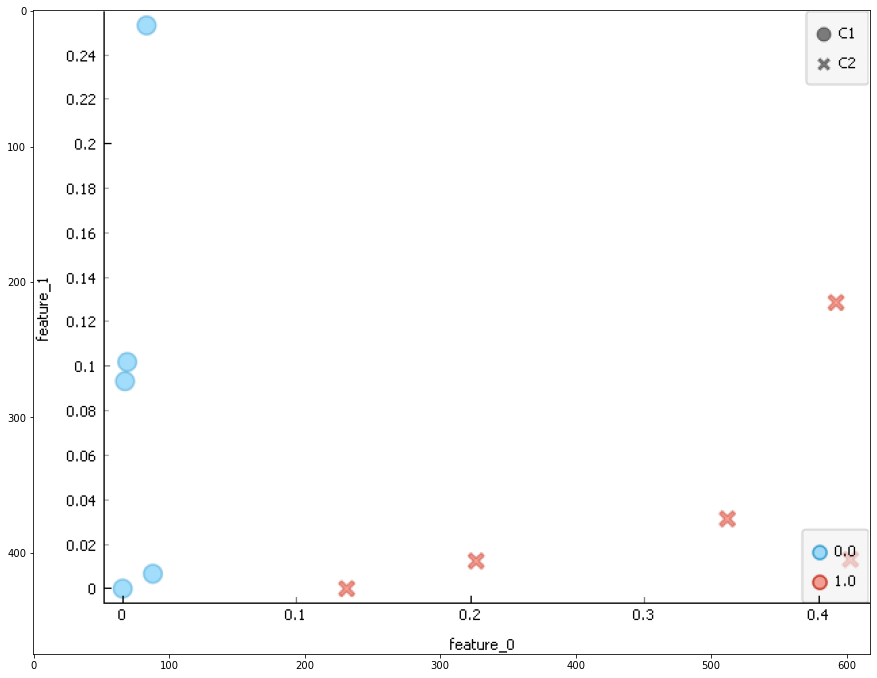

In [128]:
print("Orange workflow")
img = load_img("workflow.png")
img_array = img_to_array(img)/255.
plt.figure(figsize = (15,15))
plt.imshow(img_array)
plt.show()

print("t-SNE results:")
img = load_img("tsne.png")
img_array = img_to_array(img)/255.
plt.figure(figsize = (15,15))
plt.imshow(img_array)
plt.show()

print("Raw kmenas results:")
img = load_img("kmeans.png")
img_array = img_to_array(img)/255.
plt.figure(figsize = (15,15))
plt.imshow(img_array)
plt.show()

print("PCA + kmeans results:")
img = load_img("kmeanspca.png")
img_array = img_to_array(img)/255.
plt.figure(figsize = (15,15))
plt.imshow(img_array)
plt.show()

**TODO: Napisac krotkie wnioski:**

## **Klasyfikacja**

Wczytac model bazowy (Xception lub InceptionV3) z parametrem include_top ustawionym na False (klasyfikator dla zbioru ImageNet jest "odcinany"). Ustawic odpowiedni rozmiar warstwy wejsciowej - (299, 299, 3), ustawic parametr weights na imagenet. Model nazwij base_model.

Hint (dla Xception):

https://keras.io/api/applications/xception/

inne modele (nie wszystkie modele sa bezposrednio dostepne w tensorflow.keras.applications):

https://keras.io/api/applications/

**Na potrzeby laboratorium prosze skorzytac z modeli Xception lun InceptionV3.**, oczywiscie mozna takze "pobawic" sie innymi, ale nie jest gwarantowana ich skutecznosc :)

In [145]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


Sprawic aby parametry modelu bazowego **nie byly trenowane** - sprawdz parametr trainable modelu

Hint:

https://keras.io/guides/transfer_learning/

In [146]:
base_model.trainable = False

Z wykorzystaniem modelu bazowego (np. Xception) stworzyc swoj model do klasyfikacji binarnej zdjec. Do stworzenia modelu wykorzystac nastepujace warstwy: Input, GlobalAveragePooling2D i Dense (w warstwie powinien sie znajdowac 1 neuron. Nalezy tu wykorzystac funkcje aktywacji sigmoid - wtedy na wyjsciu zostanie zwrocona liczba z zakresu 0, 1). Model koncowy nalezy stworzyc za pomoca funkcji Model, ktora jako argumenty przyjmuje warstwe wejsciowa i wyjsciowa. Ponizej przedstawiono wyglad modelu koncowego. Koncowy model nazwac new_model - aby mozliwe bylo korzystanie z dostarczonych pozniej komorek - swoj model takze wyswietlic.

Hint:

https://keras.io/guides/transfer_learning/

In [147]:
inputs = keras.Input(shape=(299, 299, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
new_model = keras.Model(inputs, outputs)

new_model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [134]:
X.shape

(10, 299, 299, 3)

Zbudowany model skompilować (funkcja compile, optymalizator: adam, funkcja straty: binary_crossentropy, metryka do sledzenia: accuracy) oraz przetrenowac (funkcja train, podajemy X i y jako argumenty, trening ma trwac 7 epok, ale mozna sprobowac takze inne liczby - nalezy obserwowac jak zmienia sie accuracy, w zbiorze znajduje sie tylko 10 probek, wiec liczba epok nie powinna byc zbyt duza - wtedy wystepuje szansa na przetrenowanie) - ponizej wynik

In [148]:
new_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.Accuracy()])
new_model.fit(X,y, epochs=7)

Epoch 1/7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


C:\Users\Admin\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 6s 6s/step - loss: 0.6883 - accuracy: 0.0000e+00
Epoch 2/7
1/1 [==============================] - 2s 2s/step - loss: 0.6318 - accuracy: 0.0000e+00
Epoch 3/7
1/1 [==============================] - 2s 2s/step - loss: 0.5788 - accuracy: 0.0000e+00
Epoch 4/7
1/1 [==============================] - 2s 2s/step - loss: 0.5293 - accuracy: 0.0000e+00
Epoch 5/7
1/1 [==============================] - 2s 2s/step - loss: 0.4833 - accuracy: 0.0000e+00
Epoch 6/7
1/1 [==============================] - 2s 2s/step - loss: 0.4408 - accuracy: 0.0000e+00
Epoch 7/7
1/1 [==============================] - 2s 2s/step - loss: 0.4017 - accuracy: 0.0000e+00


Predykcja za pomoca wytrenowanego modelu:

In [149]:
nn_pred_train = new_model.predict(X)
print("train raw:")
print(nn_pred_train)
nn_pred_train_binary = np.round(nn_pred_train)
print("train binary:")
print(nn_pred_train_binary)

nn_pred_test = new_model.predict(X_test)
print("test raw:")
print(nn_pred_test)
nn_pred_test_binary = np.round(nn_pred_test)
print("test binary:")
print(nn_pred_test_binary)

train raw:
[[0.33165365]
 [0.23645505]
 [0.2672649 ]
 [0.30270267]
 [0.30474472]
 [0.65625036]
 [0.70614946]
 [0.72319865]
 [0.6931579 ]
 [0.6119844 ]]
train binary:
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
test raw:
[[0.27738494]
 [0.29311374]
 [0.68002367]
 [0.7462595 ]]
test binary:
[[0.]
 [0.]
 [1.]
 [1.]]


Wyznaczenie dokladnosci (accuracy) dla zbioru treningowego i testowego:

In [150]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(y, nn_pred_train_binary)
test_accuracy = accuracy_score(y_test, nn_pred_test_binary)

Graficzna prezentacja wynikow i wyswietlenie dokladnosci:

train
accuracy: 1.0


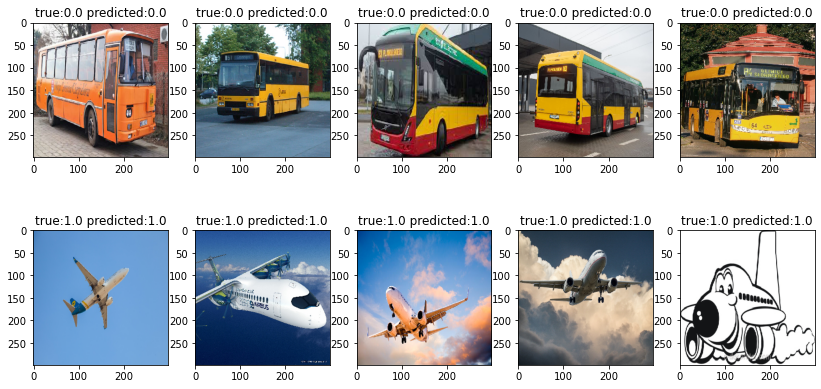

test
accuracy: 1.0


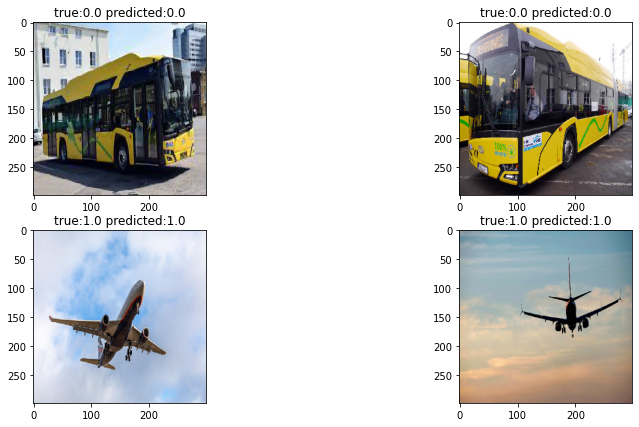

In [151]:
print("train")
print(f"accuracy: {train_accuracy}")
plot_images(X, y, rows=2, cols=5, clustering=False, nntesting=True, y_pred=nn_pred_train_binary.reshape(nn_pred_train_binary.shape[0]))
print("test")
print(f"accuracy: {test_accuracy}")
plot_images(X_test, y_test, rows=2, cols=2, clustering=False, nntesting=True, y_pred=nn_pred_test_binary.reshape(nn_pred_test_binary.shape[0]))

**TODO: Napisac krotkie wnioski:**